In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "PLN7.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =["sample_id"]#
output_cols = None
n_comps = [i for i in range(1,101)]
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/1.02") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")
preprocessing = Preprocess_Std()

Output directory is D:\workspace\lazydeep\experiments\1.03\PLN7


In [3]:
data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = CrossValEvaluation(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (10000, 129)


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="log",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="test_log",file_name=log_dir/"test_log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")
#step 1, run pls, set up pls - that runs best
n_comps = [i for i in range(1,min(101,n_features))]
pls_models = {i:PLSRegression(n_components=i) for i in n_comps}

pls_scheme = SKLearnScheme(logger="log")
scores_pls, preds_pls, model_states_pls , train_time_pls, test_time_pls = eval.evaluate(pls_models,dataset,pls_scheme,logger_name="log")
summary_logger.info(f"Train times: {train_time_pls}")
summary_logger.info(f"Test times: {test_time_pls}")
from collections import defaultdict
summary_logger.info(f"Scores: {scores_pls}")
last_r2 = -math.inf
selected_comps = -1

for i,(key,value) in enumerate(flip_dicts(scores_pls).items()):
    summary_logger.info(f"{key}: {value}")
    
for i,(key,value) in enumerate(flip_dicts(scores_pls).items()):
    new_r2  = value["R2"]
    if new_r2 - last_r2 <= 0.01:
        selected_comps = i-1
        break
    if i == 99:
        selected_comps =  min(scores_pls["MSE"],key=scores_pls["MSE"].get)
    last_r2 = new_r2

summary_logger.info(f"Selected pls preprocessing with {selected_comps} components")


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training SKLearn with a train loss of 1:413.9046,2:352.087,3:323.4328,4:305.8872,5:247.6077,6:239.3782,7:227.4649,8:220.4196,9:215.3909,10:210.8038,11:207.4409,12:203.9608,13:201.8108,14:199.8508,15:198.7739,16:197.2284,17:196.2609,18:195.6802,19:194.7197,20:194.1462,21:193.4894,22:192.6444,23:192.1024,24:191.6696,25:191.2977,26:190.8817,27:190.597,28:190.3066,29:190.1144,30:189.9125,31:189.7468,32:189.6558,33:189.5373,34:189.4269,35:189.3218,36:189.2251,37:189.1639,38:189.1,39:189.0408,40:188.9981,41:188.9576,42:188.9283,43:188.9047,44:188.8806,45:188.8639,46:188.8479,47:188.8336,48:188.8244,49:188.8174,50:188.8113,51:188.805,52:188.8001,53:188.7954,54:188.7902,55:188.7866,56:188.7831,57:188.7798,58:188.7777,59:188.7766,60:188.7758,61:188.7749,62:188.774,63:188.7733,64:188.7725,65:188.772,66:188.7716,67:188.7714,68:188.7711,6

In [6]:
eval = CrossValEvaluation(preprocessing=Preprocess_PLS(n_components=selected_comps),tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [7]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=selected_comps,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

deep_models = {name:RandomNet(input_size=selected_comps,
                             n_layers=config.n_layers,
                             act_function=config.act_function,
                             n_features = config.n_features,
                             dropout=config.dropout,
                             batch_norm=config.batch_norm,
                             device=device,dtype=torch.float)
              for name, config in configs.items()}

ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(deep_models,configs,log_dir)
start = datetime.datetime.now()
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores_deep, preds_deep, model_states_deep , train_time_deep, test_time_deep = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log")

scores_final, preds_final, model_states_ls_final , train_time_deep_final, test_time_deep_final = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log")
for model, state_dict in model_states_ls_final.items():
    torch.save(state_dict, log_dir / "models" / f"{model}" / f"_final")

summary_logger.info(f"Train times: {train_time_deep}")
summary_logger.info(f"Test times: {test_time_deep}")
from collections import defaultdict

Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Training extractors on 4999 instances, validating on 1667 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:403.951(-0.901208),random_3:inf(-0.56051),random_4:nan(-0.510167),random_5:520.8396(-0.980977),random_6:923.5802(-0.279102),random_7:690.5292(-0.486609),random_8:453.0016(-0.303297),random_9:nan(-0.78428),random_10:nan(-0.2731),random_11:nan(-0.943581),random_12:500.7668(-0.171881),random_13:nan(-0.373097),random_14:599.8154(-0.794158),random_15:579.0287(-0.337214),random_16:1949.31(-0.862446),random_17:nan(-0.447822),random_18:427.5768(-0.259096),random_19:391.6989(-0.033556),random_20:nan(-0.232474),random_21:1669.0493(-0.684561),random_22:1219.4986(-0.111175),random_23:nan(-0.10

In [8]:
ex.save_results(model_states_deep, preds_deep,configs, scores_deep, log_dir,tb,prefix="")

#summary_logger.info(f"Scores: {scores_deep}")
#for key,value in flip_dicts(scores_deep).items():
#    summary_logger.info(f"{key}: {value}")

end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, deep_models, scores_deep,prefix="")
ex.save_pred_plots(preds_deep, deep_models,log_dir)


Experiments took 3:56:24.802112'
Finished Random Deep Search'
---Loss results---'
0 - random_51 - fold_0:213.2218,fold_1:206.8959,fold_2:218.8308,fold_3:207.3381,fold_4:199.423,MSE:209.1433,R2:0.5705'
1 - random_44 - fold_0:214.7836,fold_1:191.8176,fold_2:220.6423,fold_3:213.7212,fold_4:208.8785,MSE:209.9683,R2:0.5688'
2 - random_5 - fold_0:219.7038,fold_1:207.3529,fold_2:220.1206,fold_3:214.382,fold_4:207.0431,MSE:213.7212,R2:0.5611'
3 - random_41 - fold_0:222.3465,fold_1:212.0105,fold_2:214.9442,fold_3:212.4245,fold_4:214.6796,MSE:215.2815,R2:0.5579'
4 - random_67 - fold_0:220.7574,fold_1:197.3809,fold_2:215.0507,fold_3:230.5907,fold_4:212.9406,MSE:215.3425,R2:0.5577'
5 - random_59 - fold_0:222.3729,fold_1:217.9721,fold_2:222.9939,fold_3:210.3189,fold_4:204.0587,MSE:215.5453,R2:0.5573'
6 - random_17 - fold_0:221.3394,fold_1:208.2983,fold_2:224.1741,fold_3:211.729,fold_4:215.2556,MSE:216.1599,R2:0.5561'
7 - random_4 - fold_0:219.895,fold_1:211.3813,fold_2:228.4184,fold_3:211.4088,fold

### Plotting deep results as a function of number of features

In [9]:
scores_df = pd.DataFrame(scores_deep)
scores_df.to_csv(log_dir / f"scores.csv", index=False)


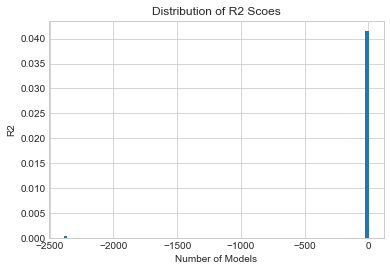

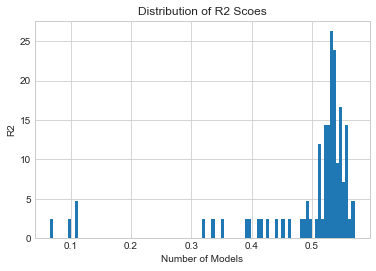

In [10]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [11]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val MSE - Val R2 - Test MSE - Test R2")
for i,key in enumerate(sorted(scores_deep['MSE'],key=scores_deep['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores_deep['MSE'][key]} -{scores_deep['R2'][key]} - {scores_final['MSE'][key]} - {scores_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val MSE - Val R2 - Test MSE - Test R2'
0 - random_51 - 209.1433053395616 -0.5704641706130309 - 209.1433053395616 - 213.4417942665215 - 0.5558365124551412'
1 - random_44 - 209.96833662613764 -0.5687697319726246 - 209.96833662613764 - 210.50454597795684 - 0.5619488038557887'
2 - random_5 - 213.72120194143088 -0.5610621454774947 - 213.72120194143088 - 205.23274622678883 - 0.5729191996546221'
3 - random_41 - 215.28149016720803 -0.557857645596163 - 215.28149016720803 - 215.49183110447692 - 0.5515704711455149'
4 - random_67 - 215.3425054605683 -0.5577323331717647 - 215.3425054605683 - 255.65035027857047 - 0.4680022646829617'
